In [1]:
## http://ddanggle.github.io/GANinTorch 참고함 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
data_mean =4 
data_stddev = 1.25


In [3]:
g_input_size =1 
g_hidden_size =50 
g_output_size =1
d_input_size =100 
d_hidden_size = 50 
d_output_size= 1 
minibatch_size = d_input_size

In [4]:
d_learning_rate =2e-4
g_learning_rate = 2e-4
optim_betas = (0.9 , 0.999)
num_epochs = 30000
print_interval = 200
d_steps = 1
g_steps =1

In [5]:
(name , preprocess , d_input_func) = ("Data and variances" , lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

In [6]:
print("using data [%s]" %(name))

using data [Data and variances]


In [7]:
def get_distribution_sampler(mu , sigma) :
    return lambda n: torch.Tensor(np.random.normal( mu , sigma, (1, n )))

def get_generator_input_sampler():
    return lambda m , n : torch.rand(m, n)

In [8]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))
    

def extract(v ) :
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d) , np.std(d)]

In [9]:
def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

In [10]:
d_sampler = get_distribution_sampler(data_mean , data_stddev)
type(d_sampler)

function

In [11]:
gi_sampler = get_generator_input_sampler()
gi_sampler

<function __main__.get_generator_input_sampler.<locals>.<lambda>(m, n)>

In [12]:
G = Generator( input_size = g_input_size , 
             hidden_size = g_hidden_size , 
             output_size = g_output_size)

D = Discriminator( input_size = d_input_func( d_input_size ) ,
                 hidden_size = d_hidden_size , 
                 output_size = d_output_size)

criterion = nn.BCELoss()

d_optimizer = optim.Adam( D.parameters() , lr=d_learning_rate , betas = optim_betas)
g_optimizer = optim.Adam( G.parameters() , lr=g_learning_rate , betas = optim_betas)

print(G)
print(D)
print(criterion)
print(d_optimizer)

Generator(
  (map1): Linear(in_features=1, out_features=50, bias=True)
  (map2): Linear(in_features=50, out_features=50, bias=True)
  (map3): Linear(in_features=50, out_features=1, bias=True)
)
Discriminator(
  (map1): Linear(in_features=200, out_features=50, bias=True)
  (map2): Linear(in_features=50, out_features=50, bias=True)
  (map3): Linear(in_features=50, out_features=1, bias=True)
)
BCELoss(
)


In [52]:
result = []
for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_data = Variable(d_sampler(d_input_size))
        d_real_decision = D(preprocess(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(preprocess(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        g_fake_data = G(gen_input)
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, Variable(torch.ones(1)))  # we want to fool, so pretend it's all genuine

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters
        
    result.append( [epoch ,  stats(extract(d_real_data))[0] , stats(extract(d_real_data))[1]
                   ,  stats(extract(d_fake_data))[0] , stats(extract(d_fake_data))[1]  ] )

    if epoch % print_interval == 0:
        print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                            extract(d_real_error)[0],
                                                            extract(d_fake_error)[0],
                                                            extract(g_error)[0],
                                                            stats(extract(d_real_data)),
                                                            stats(extract(d_fake_data))))

c:\anaconda3\envs\pytorch36\lib\site-packages\torch\nn\functional.py:1189: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0: D: 0.7335429787635803/0.759758472442627 G: 0.6436067819595337 (Real: [4.055988731980324, 1.3536200761681394], Fake: [4.641668590307236, 1.3306463943792752]) 
200: D: 0.7363520860671997/0.6700197458267212 G: 0.7496287822723389 (Real: [3.9983729392290117, 1.2855208951932533], Fake: [3.9439189141988753, 1.3668806809468153]) 
400: D: 0.6227584481239319/0.7520610094070435 G: 0.670663595199585 (Real: [3.743639752268791, 1.2664025107250023], Fake: [3.700444659888744, 1.2228263735949472]) 
600: D: 0.6963411569595337/0.7926178574562073 G: 0.6566158533096313 (Real: [3.8691880095005033, 1.2426123985905155], Fake: [3.815265004634857, 1.2815405354640288]) 
800: D: 0.7560557126998901/0.6727355718612671 G: 0.6093512177467346 (Real: [4.202530413866043, 1.3161817715284059], Fake: [3.966341811418533, 1.2451802591813959]) 
1000: D: 0.6443071365356445/0.6033216118812561 G: 0.8052297234535217 (Real: [3.872777087688446, 1.2299331781616343], Fake: [4.4961627113819125, 1.264837018176809]) 
1200: D: 0.70342

10000: D: 0.7181664109230042/0.7653622627258301 G: 0.6630851626396179 (Real: [3.7702024930715563, 1.1164433011739492], Fake: [4.586275261640549, 1.2559301368543068]) 
10200: D: 0.7011627554893494/0.6670729517936707 G: 0.7559088468551636 (Real: [3.990702041387558, 1.2589168188701934], Fake: [4.14419872045517, 1.3677679747089697]) 
10400: D: 0.559934139251709/0.6818601489067078 G: 0.6866684556007385 (Real: [4.095959459245205, 1.360845974264793], Fake: [3.6009844332933425, 1.2260805445747656]) 
10600: D: 0.7754165530204773/0.7387745976448059 G: 0.7652136087417603 (Real: [4.124859181642532, 1.2553829805608077], Fake: [3.899847779273987, 1.0978266744987721]) 
10800: D: 0.7405899167060852/0.6701884269714355 G: 0.7334582805633545 (Real: [4.056153330206871, 0.978285815422531], Fake: [4.2626557338237765, 1.3379930251775107]) 
11000: D: 0.49433958530426025/0.5693349242210388 G: 0.7562278509140015 (Real: [3.9870972856506706, 1.389113318503526], Fake: [4.606275153160095, 1.3340484893868276]) 
1120

20000: D: 0.6960200667381287/0.6953602433204651 G: 0.6962610483169556 (Real: [4.0294600617885585, 1.3004007702070164], Fake: [3.5593576830625535, 1.0970277015635745]) 
20200: D: 0.7011412978172302/0.7290332913398743 G: 0.63570636510849 (Real: [4.000690847039222, 1.0975568689917423], Fake: [3.9715837013721464, 1.1964927385847768]) 
20400: D: 0.6921035647392273/0.5978668332099915 G: 0.8057885766029358 (Real: [3.9014123141765595, 1.1042314293152584], Fake: [4.513244875669479, 1.354650502641566]) 
20600: D: 0.7076715230941772/0.6404410004615784 G: 0.7753713130950928 (Real: [4.132678555250168, 1.355174768510723], Fake: [4.478313578367233, 1.464555072802922]) 
20800: D: 0.6915678381919861/0.7452073097229004 G: 0.5819241404533386 (Real: [4.047982466220856, 1.3511255393477535], Fake: [4.436081299781799, 1.3347843527384098]) 
21000: D: 0.6509471535682678/0.6234709024429321 G: 0.7857365012168884 (Real: [4.093557340502739, 1.3586910492767097], Fake: [3.9871715259552003, 1.056250534374808]) 
21200

In [53]:
import pandas as pd
np.array(result).shape

(30000, 5)

In [55]:
## 저장시키기

with open("gan_distribution.txt" , "wb") as fp :
    pickle.dump(result , fp)

In [8]:
## load 하기 
import pickle
import pandas as pd 
with open("gan_distribution.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

In [9]:
data = pd.DataFrame(b)


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

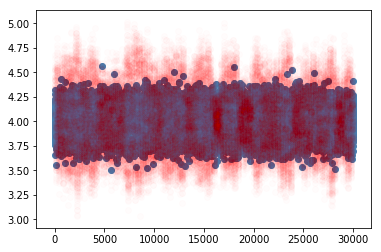

In [11]:
plt.scatter( data[0] , data[1] , color="steelblue" , alpha=1)
plt.scatter( data[0] , data[3] , color="red" , alpha=0.01)
plt.show()

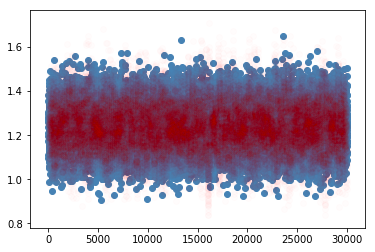

In [12]:
plt.scatter( data[0] , data[2] , color="steelblue" , alpha=1)
plt.scatter( data[0] , data[4] , color="red" , alpha=0.01)
plt.show()

In [ ]:
import matplotlib.mlab as mlab
import math
import numpy as np
for i in range(data.shape[0]) :
    mu = data[1][i]
    sigma = data[2][i]
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x,mlab.normpdf(x, mu, sigma))
    mu = data[3][i]
    sigma = data[4][i]
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x,mlab.normpdf(x, mu, sigma) , color="red")
    plt.show()



In [113]:
from matplotlib import animation
def init():
    line.set_data([], [])
    return line,

def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

range(0, 30000)

In [106]:
data.rows

AttributeError: 'DataFrame' object has no attribute 'rows'